# 과제2

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/2024년 카이스트 고급 금융 계량/과제2")

이 과제에서는 시계열 프레임워크를 사용하여 자산 가격 모델을 평가하고 테스트합니다. Gibbons, Ross, Shanken(GRS) 테스트를 사용합니다.  

본과제를 위해서 "Problem_Set_2.xls" 파일이 필요합니다. 이 파일에는 다음의 4개의 스프레드시트가 포함되어 있습니다:

1) 30개의 산업 가치 가중 포트폴리오 수익률

2) 단기- 중기 과거 (모멘텀) 수익률(t 2에서 t 12까지)로 구성된 10개 포트폴리오(*이 포트폴리오는 1926년 7월이 아닌 1927년 1월부터 시작됨)

3) 규모와 BE/ME를 기준으로 형성된 25개 포트폴리오,

4) 그리고 시장 포트폴리오의 프록시(RM-RF).


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 데이터 전처리

In [ ]:
#--------------------Read subsheet 1--------------------
sheet1=pd.read_excel("Problem_Set_2.xls", sheet_name='Industry portfolios (VW)',
                     skiprows=2, index_col=None)
sheet1["Date"] = pd.to_datetime(sheet1["Unnamed: 0"], format="%Y%m")
VWreturn = sheet1.set_index("Date")
VWreturn = VWreturn.loc[VWreturn.index.dropna()]
VWreturn = VWreturn.drop("Unnamed: 0", axis = 1)

#--------------------Read subsheet 2--------------------
sheet2=pd.read_excel("Problem_Set_2.xls", sheet_name='Past return portfolios',
                     skiprows=8, index_col=None)
sheet2["Date"] = pd.to_datetime(sheet2["Date"], format="%Y%m")
pastreturn = sheet2.set_index("Date")
pastreturn = pastreturn.loc[pastreturn.index.dropna()]

#--------------------Read subsheet 3--------------------
sheet3=pd.read_excel("Problem_Set_2.xls", sheet_name='25 size and BEME portfolios',
                     skiprows=2, index_col=None)
sheet3["Date"] = pd.to_datetime(sheet3["BE/ME"], format="%Y%m")
BEME = sheet3.set_index("Date")
BEME = BEME.loc[BEME.index.dropna()]
BEME = BEME.drop("BE/ME", axis = 1)

#--------------------Read subsheet 4--------------------
sheet4=pd.read_excel("Problem_Set_2.xls", sheet_name='Market, Rf',
                     skiprows=1, index_col=None)
sheet4["Date"] = pd.to_datetime(sheet4["Unnamed: 0"], format="%Y%m")
rm_rf = sheet4.set_index("Date")
rm_rf = rm_rf.loc[rm_rf.index.dropna()]
rm_rf = rm_rf.drop("Unnamed: 0", axis = 1)

# 1부:  30 시가가중 산업 포트폴리오 (Value-Weight Industry portfolios)



### a) 30개의 시가가중 산업 포트폴리오를 사용하여 각 포트폴리오의 수익률의 표본 평균과 표준 편차를 계산하세요. 포트폴리오의 평균 수익률 또는 샤프 비율에 식별 가능한 패턴이 있습니까?



In [ ]:
VW_mean = VWreturn.mean()
VW_sd = VWreturn.std()
VW_sharpe = VW_mean/VW_sd
VW_summary = pd.DataFrame({'Mean': VW_mean, 'Standard Deviation': VW_sd, 'Sharpe Ratio':VW_sharpe})
VW_summary

,Mean,Standard Deviation,Sharpe Ratio
Food,0.988026,4.782731,0.206582
Beer,1.217278,7.287126,0.167045
Smoke,1.170037,5.818110,0.201103
Games,1.124911,9.003746,0.124938
Books,0.942479,7.210720,0.130705
Hshld,0.933442,5.879326,0.158767
Clths,0.953414,6.140737,0.155261
Hlth,1.106623,5.598703,0.197657
Chems,1.062900,6.326091,0.168018
Txtls,1.027016,7.711474,0.133180


(0.0, 0.25)

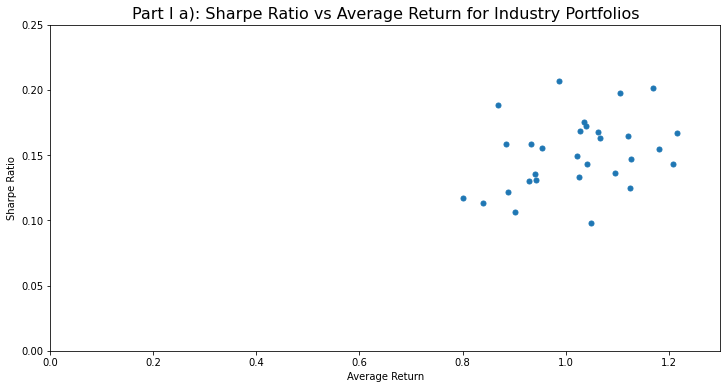

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(VW_mean, VW_sharpe, '.', markersize=10)
plt.xlabel('Average Return')
plt.ylabel('Sharpe Ratio');
plt.title('Part I a): Sharpe Ratio vs Average Return for Industry Portfolios', fontsize=16)
plt.xlim(0, 1.3)
plt.ylim(0, 0.25)

In [ ]:
x = sm.add_constant(VW_summary['Mean'])
mod1 = sm.OLS(VW_summary["Sharpe Ratio"],x, data = VW_summary).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sharpe Ratio   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     3.500
Date:                Mon, 28 Sep 2020   Prob (F-statistic):             0.0718
Time:                        01:36:00   Log-Likelihood:                 67.331
No. Observations:                  30   AIC:                            -130.7
Df Residuals:                      28   BIC:                            -127.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0669      0.045      1.478      0.151      -0.026       0.160
Mean           0.0825      0.044      1.871      0.072      -0.008       0.173
==============================================================================
Omnibus:                        0.729   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.546
Skew:                           0.317   Prob(JB):                        0.761
Kurtosis:                       2.813   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

검사를 해보면, 30개 포트폴리오의 평균 수익률이나 샤프 비율에서 뚜렷한 패턴이 발견되지 않습니다.

평균 수익률에 대한 샤프 비율을 플롯하면 두 데이터 세트 간에 강력하거나 식별할 수 있는 패턴이 없음을 알 수 있습니다. 긍정적인 관계가 있을 수도 있지만, 기껏해야 약한 관계일 뿐입니다.

또한 샤프 비율과 수익률 간의 회귀 분석을 실행한 결과, 양(+)의 관계(평균 계수 0.0825)가 있을 수 있지만 평균 수익률은 0.111의 낮은 R-제곱으로 샤프 비율의 상당 부분을 통계적으로 설명할 수 없는 것으로 나타났습니다.

## b) 시계열 회귀를 추정하세요.
$R_{p t}-R_{f t}=a+\beta_{i M}\left(R_{M t}-R_{f t}\right)+e_{i t}, $

30개 산업 포트폴리오 각각에 대해. 다변량 GRS 테스트를 수행하여 GRS F-통계치와 해당 p-값을 모두 보고하세요. 시장 포트폴리오 프록시 RM-RF를 사용합니다.

다음 공식을 사용하여 테스트 통계를 계산합니다.

$$F_{test} = \frac{T-N-1}{N} \frac{\alpha^{\prime} \sum^{-1} \alpha}{1+\frac{\mu_{m}^{2}}{\sigma_{m}^{2}}}
$$

In [ ]:
y = VWreturn.subtract(rm_rf['RF'],axis=0)
y = y[0:1069] # drop the last 4 NA rows
x = sm.add_constant(rm_rf['RM-RF'])[0:1069]

alpha = []
beta = []
eps = []

for pf in VWreturn.columns:
    y_in = y[pf]
    mod = sm.OLS(y_in,x,missing = 'drop').fit()
    alpha.append(mod.params[0])
    beta.append(mod.params[1])
    eps.append(mod.resid)

T = VWreturn.shape[0]
N = VWreturn.shape[1]

eps_df = pd.DataFrame(eps).T
var_cov = eps_df.cov() # (30,30)

# create Rm column in rm_rf
rm_rf['RM'] = rm_rf['RM-RF'] + rm_rf['RF']

F = ((T-N-1)/N)* ((alpha @ np.linalg.inv(var_cov) @ np.transpose(alpha)) / (1+(rm_rf['RM'][0:1069].mean()/rm_rf['RM'][0:1069].std())**2))
p_value = f.sf(F, N, T-N-1)
print("F statistic: ", F, "p value: ", p_value)

coeff_summary = pd.DataFrame({'industry':VWreturn.columns, 'alpha': alpha, 'beta': beta})
coeff_summary

F statistic:  1.8866758085893187 p value:  0.0028413192986861003


,industry,alpha,beta
0,Food,0.221191,0.742113
1,Beer,0.317012,0.946365
2,Smoke,0.475272,0.631790
3,Games,-0.064326,1.388714
4,Books,-0.061619,1.105308
5,Hshld,0.059851,0.905533
6,Clths,0.137579,0.817121
7,Hlth,0.277770,0.837047
8,Chems,0.102647,1.038191
9,Txtls,-0.000195,1.140688


$p = 0.028 < 0.05$이므로 $\alpha$ 값이 0이라는 귀무가설을 거부하며, 이는 시장 포트폴리오 프록시로 수익률을 완전히 설명할 수 없다는 것을 의미합니다(이 경우 초과 시장 수익률 (Rm - Rf)). 즉, 테스트에 사용된 시장 포트폴리오 프록시는 평균 분산에 효율적이지 않다는 뜻입니다.

## c) GRS 테스트의 귀무가설은 무엇이며(정확히 말하라), 이것이 어떻게 CAPM의 테스트가 되는가?  GRS 테스트를 직관적으로 설명하십시오.  시계열 회귀분석은 어떻게 베타 위험 프리미엄을 암시적으로 추정하나요?




$$
r_{i,t} - r_{f,t}=\alpha_{i}+\beta_{i} (R_{m,t} - r_{f,t} )+\varepsilon_{i,t} \space \forall i=1, \ldots \ldots, N
$$

$$
H_0: \alpha_{i}=0 \space \forall i=1, \ldots \ldots, N
$$

GRS 테스트의 귀무가설은 시계열 회귀에서 각 자산의 $\alpha$ 값이 0이며, 이는 시장 포트폴리오의 초과 수익률 외에 자산의 수익률을 설명할 수 있는 다른 요인이 없다는 것입니다.

샤프-린트너 CAPM에 따르면, 다른 자산 Z(단순화를 위해 보통 무위험 자산)에 대한 자산 i의 초과 수익률의 기대값은 시장 포트폴리오의 초과 수익률로 완전히 설명되어야 합니다. 따라서

$E[r_i - r_f] = \beta_i E[R_m - r_f]$.

CAPM이 참이 되려면 회귀의 절편이 0이어야 하고, 따라서 귀무가설은 $\alpha$ 값이 0이어야 하며, 따라서 GRS 검정은 CAPM을 테스트하는 것임을 알 수 있습니다. 귀무가설을 기각한다는 것은 시장 포트폴리오가 평균 분산 효율적이지 않다는 것, 즉 $\beta$가 자산 i의 기대 초과수익률을 완전히 포착할 수 없다는 것, 즉 자산 i의 초과수익률에 기여한 다른 요인이 있고 그 요인은 이제 $\alpha$에 의해 포착된다는 것을 의미합니다.

직관적으로 GRS 테스트는 시장 포트폴리오의 샤프 비율이 가능한 최대 값인지 테스트하는 것입니다. 이를 기각하는 것은 데이터에서 평균 분산 효율이 더 높은 포트폴리오가 존재한다는 의미이며, 따라서 GRS 테스트에 따른 현재 포트폴리오는 평균 분산 효율이 높지 않다는 것을 의미합니다.

### d) 부호와 절편의 크기에 대해 설명하세요.  CAPM이 어떠한 포트폴리오의 가격을 결정하는 데 특별한 어려움이 있습니까? 그 이유는 무엇인가요?

(-0.5, 0.6)

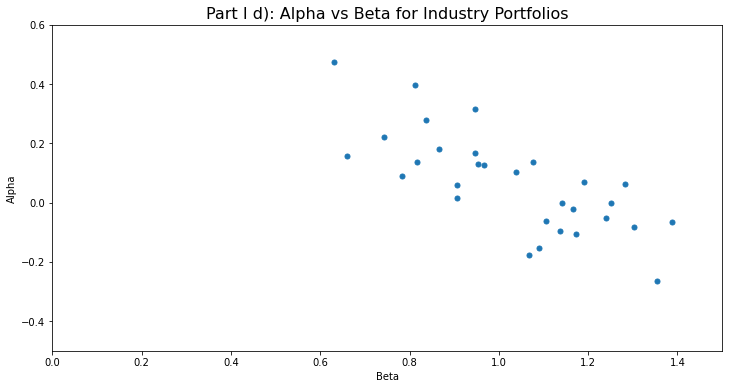

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(coeff_summary['beta'], coeff_summary['alpha'], '.', markersize=10)
plt.xlabel('Beta')
plt.ylabel('Alpha');
plt.title('Part I d): Alpha vs Beta for Industry Portfolios', fontsize=16)
plt.xlim(0, 1.5)
plt.ylim(-0.5, 0.6)

위의 알파 대 베타 그래프를 보면, 절편/$\alpha$의 부호와 크기는 -0.4에서 0.4까지 다양하지만 0을 중심으로 어느 정도 고르게 분포되어 있는 것을 알 수 있습니다.

또한 $\alpha$와 $\beta$ 사이에는 음의 관계가 있는 것으로 보이며, $\alpha$ = 0과 $\beta$ = 1을 중심으로 합니다. CAPM에 따르면 시장 전체가 이 값을 중심으로 움직여야 하기 때문에, 즉 시장 포트폴리오가 다른 요인 없이 그 자체로 시장을 설명하기 때문에 이러한 중심은 당연한 것입니다.

그럼에도 불구하고 스모크 및 철강 산업과 같이 베타가 특히 높거나 낮은 포트폴리오의 경우 해당 절편/$\alpha$ 값이 특히 높거나 낮기 때문에 CAPM으로 가격을 결정하는 데 어려움이 있음을 알 수 있습니다. $\beta$를 시장 포트폴리오와 비교할 때 자산의 변동성과 위험도를 나타내는 것으로 해석하면, CAPM이 위험/변동성이 매우 높거나 낮은 자산을 포착하는 데 어려움이 있으며, 이러한 자산의 수익률에는 $\beta$ 이외의 추가 요인이 있다는 것을 의미합니다.

# 파트 II: 과거 수익률 포트폴리오 10개

## e) 과거 수익률 포트폴리오 10개에 대해 a), b), d) 부분을 반복하세요.


In [ ]:
# Repeat a) for 10 past return portfolios
past_mean = pastreturn.mean()
past_sd = pastreturn.std()
past_sharpe = past_mean/past_sd
past_summary = pd.DataFrame({'Mean': past_mean, 'Standard Deviation': past_sd, 'Sharpe Ratio': past_sharpe})
past_summary

,Mean,Standard Deviation,Sharpe Ratio
Loser,0.302803,9.798304,0.030904
2,0.691421,8.077977,0.085593
3,0.748363,7.009402,0.106766
4,0.876877,6.382101,0.137396
5,0.880659,5.972757,0.147446
6,0.942963,5.827731,0.161806
7,1.024431,5.517353,0.185674
8,1.134779,5.363983,0.211555
9,1.211204,5.653341,0.214246
Winner,1.521853,6.509572,0.233787


(0.0, 0.25)

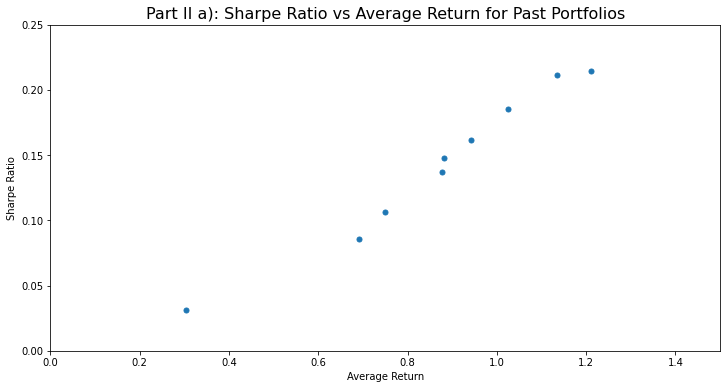

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(past_mean, past_sharpe, '.', markersize=10)
plt.xlabel('Average Return')
plt.ylabel('Sharpe Ratio');
plt.title('Part II a): Sharpe Ratio vs Average Return for Past Portfolios', fontsize=16)
plt.xlim(0, 1.5)
plt.ylim(0, 0.25)

In [ ]:
x = sm.add_constant(past_summary['Mean'])
mod2 = sm.OLS(past_summary["Sharpe Ratio"], x, data = past_summary).fit()
mod2.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Sharpe Ratio   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     117.6
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           4.61e-06
Time:                        01:36:00   Log-Likelihood:                 27.620
No. Observations:                  10   AIC:                            -51.24
Df Residuals:                       8   BIC:                            -50.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0243      0.017     -1.421      0.193      -0.064       0.015
Mean           0.1883      0.017     10.846      0.000       0.148       0.228
==============================================================================
Omnibus:                        0.602   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.575
Skew:                          -0.416   Prob(JB):                        0.750
Kurtosis:                       2.171   Cond. No.                         6.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

조사 결과, 과거 10개 수익률 포트폴리오의 평균 수익률과 샤프 비율 사이에는 분명한 양의 관계가 있습니다.

평균 수익률에 대한 샤프 비율을 플롯하면 두 변수 간에 강력하고 거의 선형적인 관계가 있음을 알 수 있습니다.

이는 샤프비율과 수익률 간의 회귀분석을 통해 확인할 수 있으며, 그 결과 평균 수익률이 0.936의 높은 R-제곱으로 샤프비율의 많은 부분을 통계적으로 설명하는 매우 강력한 양의 관계(평균 계수 0.1883)를 보여줍니다.

In [ ]:
# Repeat b) for 10 past return portfolios
new_rm_rf = rm_rf.iloc[6:1069]
y = pastreturn.subtract(new_rm_rf['RF'], axis=0)
x = sm.add_constant(rm_rf['RM-RF'])[6:1069]

alpha_1 = []
beta_1 = []
eps_1 = []

for pf in pastreturn.columns:
    y_in = y[pf]
    mod = sm.OLS(y_in, x, missing = 'drop').fit()
    alpha_1.append(mod.params[0])
    beta_1.append(mod.params[1])
    eps_1.append(mod.resid)

T = pastreturn.shape[0]
N = pastreturn.shape[1]

eps_df = pd.DataFrame(eps_1).T
var_cov = eps_df.cov() # (10,10)

F = ((T-N-1)/N)* ((alpha_1 @ np.linalg.inv(var_cov) @ np.transpose(alpha_1)) / (1+(new_rm_rf['RM'].mean()/new_rm_rf['RM'].std())**2))
p_value = f.sf(F, N, T-N-1)
print("F statistic: ", F, "p value: ", p_value)

coeff_summary_1 = pd.DataFrame({'industry':pastreturn.columns, 'alpha': alpha_1, 'beta': beta_1})
coeff_summary_1

F statistic:  6.49583143114609 p value:  8.67295161536779e-10


,industry,alpha,beta
0,Loser,-0.990460,1.556692
1,2,-0.452873,1.327348
2,3,-0.296916,1.174913
3,4,-0.116117,1.094417
4,5,-0.075635,1.037916
5,6,-0.009241,1.031621
6,7,0.112284,0.969952
7,8,0.245541,0.934681
8,9,0.301975,0.965458
9,Winner,0.574967,1.023433


$p$ ~ 0 < 0.05이므로 $\alpha$ 값이 0이라는 귀무가설을 거부하며, 이는 시장 포트폴리오 프록시로 수익률을 완전히 설명할 수 없다는 것을 의미합니다(이 경우 초과 시장 수익률(Rm - Rf)). 즉, 테스트의 시장 포트폴리오 프록시가 평균 분산 효율적이지 않다는 결론을 1부보다 더 강력하게 내릴 수 있습니다.

이러한 과거 포트폴리오의 구성에는 포트폴리오 매니저의 기술(skill)이 포함될 수 있으므로 평균 분산 효율에 더 가까운 포트폴리오를 나타내야 하며, 이는 당연한 결과입니다.

(-1.1, 0.7)

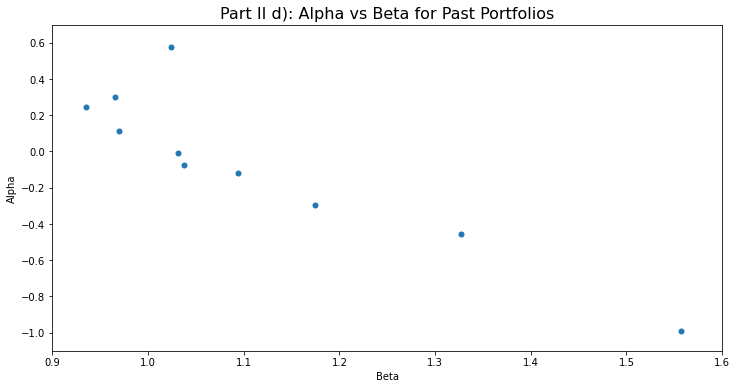

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(coeff_summary_1['beta'], coeff_summary_1['alpha'], '.', markersize=10)
plt.xlabel('Beta')
plt.ylabel('Alpha');
plt.title('Part II d): Alpha vs Beta for Past Portfolios', fontsize=16)
plt.xlim(0.9, 1.6)
plt.ylim(-1.1, 0.7)

위의 알파 대 베타 그래프에서 볼 수 있듯이 절편/$\alpha$의 부호와 크기는 -1.0에서 0.6까지 다양하며, 10개 포트폴리오 중 6개가 음의 $\alpha$ 값을 갖는 것을 알 수 있습니다. 절편값의 부호는 대부분 패자의 경우 음수이고 승자의 경우 양수입니다.

$\alpha$를 시장 초과 수익률로 설명되지 않는 수익률로, 포트폴리오 매니저의 '기술'이 창출한 추가 가치로, $\beta$를 위험도로 해석하면, 흥미롭게도 $\alpha$ 대 $\beta$ 플롯이 효율적 프론티어 모양과 다소 유사하다는 것을 알 수 있습니다.

상위 영역에서는 $\alpha$와 $\beta$ 사이에 양의 관계가 있으며 $\alpha$가 0보다 높습니다. 이는 포트폴리오가 더 많은 위험을 감수하지만 포트폴리오 매니저가 창출하는 긍정적인 가치, 즉 고위험 고수익이 존재한다는 것을 의미합니다.

그러나 하위 영역에서는 $\alpha$와 $\beta$ 사이에 음의 관계가 나타나며 $\alpha$가 0보다 낮습니다. 이는 포트폴리오가 더 많은 위험을 감수하지만 포트폴리오 매니저가 창출한 음의 가치, 즉 가치 파괴, 고위험 저수익이 존재한다는 것을 의미합니다.

특히 CAPM은 매우 높은 $\beta$ 포트폴리오의 가치를 평가하는 데 어려움을 겪습니다. 포트폴리오 매니저가 너무 많은 위험을 감수하기 때문에 그들의 '기술'이 시장이 설명할 수 있는 것 이상으로 가치를 파괴하고 있다는 설명이 가능합니다.

# 3부:  25 Size와 BE/ME 포트폴리오


### f) 25사이즈와 BE/ME 포트폴리오에 대해 a), b), d) 부분을 반복하세요.
